### LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dtaidistance import clustering, dtw
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

### BY-YEAR SERIES CLUSTERING

In [2]:
df = pd.read_csv('../data/time_series/ts_total.csv', index_col='date', 
                 parse_dates=True)

In [3]:
ts_by_year_matrix = np.array(
    [df.loc['{}-01-01'.format(year):'{}-12-01'.format(year)].values.
     reshape(1, -1)[0] for year in range(2008, 2017)])

#### HIERARCHICAL CLUSTERING

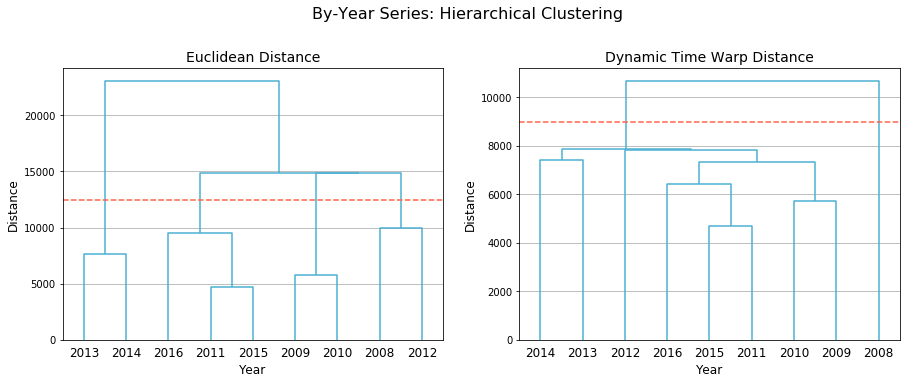

In [4]:
plt.figure(figsize=(15, 5))

plt.suptitle('By-Year Series: Hierarchical Clustering', fontsize=16, y=1.05)

plt.subplot(1, 2, 1)
dendrogram(linkage(ts_by_year_matrix, method='ward', metric='euclidean'), 
           labels=range(2008, 2017), link_color_func=lambda k: '#4bafd1')
plt.axhline(y=12500, color='tomato', linestyle='--')
plt.grid(axis='y')
plt.title('Euclidean Distance', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Distance', fontsize=12)

plt.subplot(1, 2, 2)
model = clustering.HierarchicalTree(clustering.
                                     Hierarchical(dtw.distance_matrix, {}))
cluster_idx = model.fit(ts_by_year_matrix)
dendrogram(model.linkage, labels=range(2008, 2017),
           link_color_func=lambda k: '#4bafd1')
plt.axhline(y=9000, color='tomato', linestyle='--')
plt.title('Dynamic Time Warp Distance', fontsize=14)
plt.grid(axis='y')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Distance', fontsize=12)

plt.savefig('../imgs/clustering/by_year_hierarchical.pdf', bbox_inches='tight')

#### K-MEANS CLUSTERING

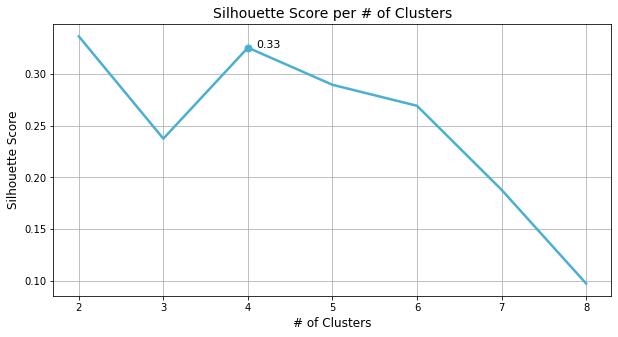

In [5]:
silhouette_scores = []

for n_clusters in range(2, 9):
    kmeans = KMeans(n_clusters=n_clusters).fit(ts_by_year_matrix)
    silhouette_scores.append(silhouette_score(ts_by_year_matrix, 
                                              kmeans.labels_))
    
plt.figure(figsize=(10, 5))
plt.plot(range(0, 7), silhouette_scores, color='#4bafd1', linewidth=2.5,
         marker='o', markersize=7.0, markevery=[2])
plt.annotate(round(silhouette_scores[2], 2), (2.1, silhouette_scores[2]),
             fontsize=11)
plt.grid()
plt.xticks(ticks=range(0, 7), labels=range(2, 9))
plt.xlabel('# of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score per # of Clusters', fontsize=14)
plt.savefig('../imgs/clustering/sc_by_year_series.pdf', bbox_inches='tight')

In [6]:
kmeans = pd.DataFrame(data=KMeans(n_clusters=4).fit_predict(ts_by_year_matrix),
                      index=range(2008, 2017), columns=['Cluster'])
kmeans.index.name = 'Year'

kmeans

,Cluster
Year,
2008,0
2009,2
2010,2
2011,1
2012,0
2013,3
2014,3
2015,1
2016,1


### BY-BOROUGH SERIES CLUSTERING

In [7]:
df = pd.read_csv('../data/time_series/ts_borough.csv', index_col='date', 
                 parse_dates=True)

In [8]:
ts_by_borough_matrix = np.array(
    [df[df['borough'] == b].sort_index()['value'].values 
     for b in df['borough'].unique()])

#### HIERARCHICAL CLUSTERING

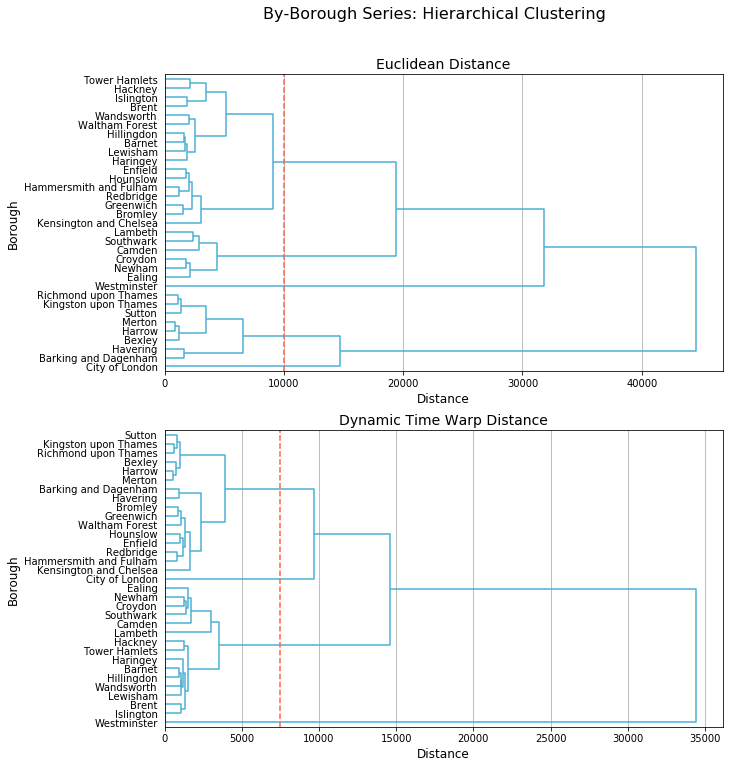

In [9]:
plt.figure(figsize=(10, 12))

plt.suptitle('By-Borough Series: Hierarchical Clustering', fontsize=16,
             va='center', ha='center', y=0.95)

plt.subplot(2, 1, 1)
dendrogram(linkage(ts_by_borough_matrix, method='ward', metric='euclidean'), 
           labels=df['borough'].unique(), orientation='right', 
           leaf_font_size=10, link_color_func=lambda k: '#4bafd1')
plt.axvline(x=10000, color='tomato', linestyle='--')
plt.title('Euclidean Distance', fontsize=14)
plt.grid(axis='x')
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Borough', fontsize=12)

plt.subplot(2, 1, 2)
model = clustering.HierarchicalTree(clustering.
                                    Hierarchical(dtw.distance_matrix, {}))
cluster_idx = model.fit(ts_by_borough_matrix)
dendrogram(model.linkage, labels=df['borough'].unique(), orientation='right', 
           leaf_font_size=10, link_color_func=lambda k: '#4bafd1')
plt.axvline(x=7500, color='tomato', linestyle='--')
plt.title('Dynamic Time Warp Distance', fontsize=14)
plt.grid(axis='x')
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Borough', fontsize=12)

plt.savefig('../imgs/clustering/by_borough_hierarchical.pdf', 
            bbox_inches='tight')

#### K-MEANS CLUSTERING

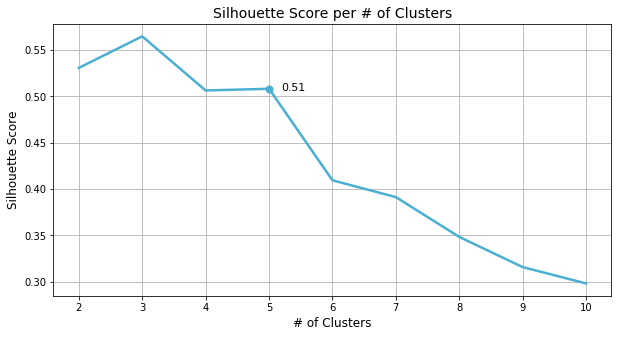

In [10]:
silhouette_scores = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters).fit(ts_by_borough_matrix)
    silhouette_scores.append(silhouette_score(ts_by_borough_matrix, 
                                              kmeans.labels_))
    
plt.figure(figsize=(10, 5))
plt.plot(range(0, 9), silhouette_scores, color='#4bafd1', linewidth=2.5,
         marker='o', markersize=7.0, markevery=[3])
plt.annotate(round(silhouette_scores[3], 2), (3.2, silhouette_scores[2]),
             fontsize=11)
plt.grid()
plt.xticks(ticks=range(0, 9), labels=range(2, 11))
plt.xlabel('# of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score per # of Clusters', fontsize=14)
plt.savefig('../imgs/clustering/sc_by_borough_series.pdf', bbox_inches='tight')

In [11]:
kmeans = pd.DataFrame(data=KMeans(n_clusters=5).fit_predict(ts_by_borough_matrix),
                      index=df['borough'].unique(), columns=['Cluster'])
kmeans.index.name = 'Borough'

kmeans

,Cluster
Borough,
Sutton,3
Barking and Dagenham,3
Ealing,4
Hackney,0
Bromley,0
Newham,4
Croydon,4
Bexley,3
Hounslow,0


### BY-MAJOR CATEGORY SERIES CLUSTERING

In [12]:
df = pd.read_csv('../data/time_series/ts_major_cat.csv', index_col='date', 
                 parse_dates=True)

In [13]:
ts_by_major_cat_matrix = np.array(
    [df[df['major_category'] == mc].sort_index()['value'].values 
     for mc in df['major_category'].unique()])

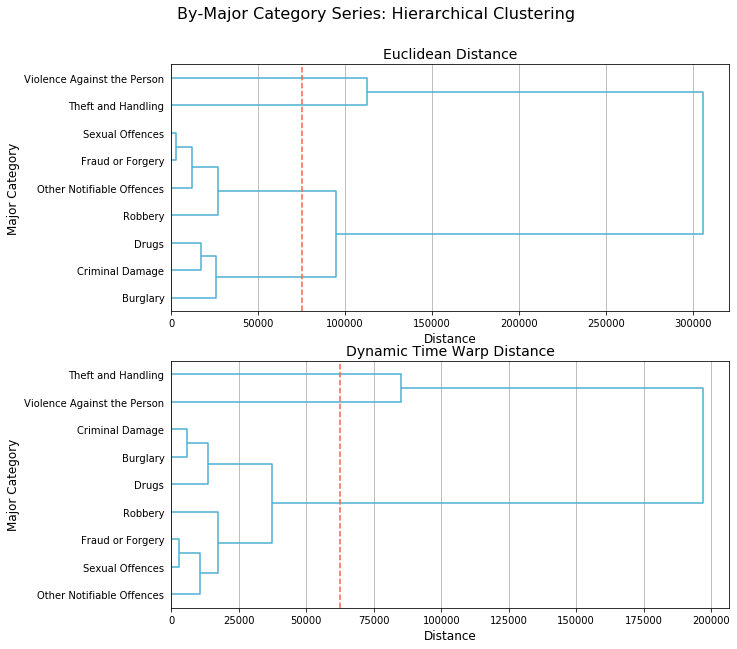

In [14]:
plt.figure(figsize=(10, 10))

plt.suptitle('By-Major Category Series: Hierarchical Clustering', fontsize=16,
             va='center', ha='center', x=0.41, y=0.95)

plt.subplot(2, 1, 1)
dendrogram(linkage(ts_by_major_cat_matrix, method='ward', metric='euclidean'), 
           labels=df['major_category'].unique(), orientation='right', 
           leaf_font_size=10, link_color_func=lambda k: '#4bafd1')
plt.axvline(x=75000, color='tomato', linestyle='--')
plt.title('Euclidean Distance', fontsize=14)
plt.grid(axis='x')
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Major Category', fontsize=12)

plt.subplot(2, 1, 2)
model = clustering.HierarchicalTree(clustering.
                                    Hierarchical(dtw.distance_matrix, {}))
cluster_idx = model.fit(ts_by_major_cat_matrix)
dendrogram(model.linkage, labels=df['major_category'].unique(), 
           orientation='right', leaf_font_size=10, 
           link_color_func=lambda k: '#4bafd1')
plt.axvline(x=62500, color='tomato', linestyle='--')
plt.title('Dynamic Time Warp Distance', fontsize=14)
plt.grid(axis='x')
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Major Category', fontsize=12)

plt.savefig('../imgs/clustering/by_major_category_hierarchical.pdf',
            bbox_inches='tight')

#### K-MEANS CLUSTERING

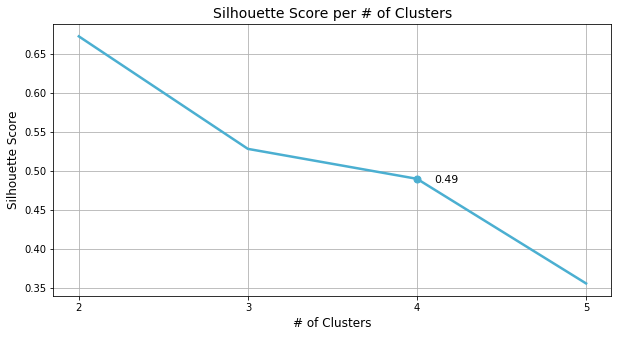

In [15]:
silhouette_scores = []

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters).fit(ts_by_major_cat_matrix)
    silhouette_scores.append(silhouette_score(ts_by_major_cat_matrix, 
                                              kmeans.labels_))
    
plt.figure(figsize=(10, 5))
plt.plot(range(0, 4), silhouette_scores, color='#4bafd1', linewidth=2.5,
         marker='o', markersize=7.0, markevery=[2])
plt.annotate(round(silhouette_scores[2], 2), (2.1, 
                                              silhouette_scores[2] - 0.005),
             fontsize=11)
plt.grid()
plt.xticks(ticks=range(0, 4), labels=range(2, 6))
plt.xlabel('# of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score per # of Clusters', fontsize=14)
plt.savefig('../imgs/clustering/sc_by_major_cat_series.pdf', 
            bbox_inches='tight')

In [16]:
kmeans = pd.DataFrame(data=KMeans(n_clusters=4).fit_predict(ts_by_major_cat_matrix),
                      index=df['major_category'].unique(), columns=['Cluster'])
kmeans.index.name = 'Major Category Crime'

kmeans

,Cluster
Major Category Crime,
Theft and Handling,0
Criminal Damage,3
Burglary,3
Violence Against the Person,2
Robbery,1
Drugs,3
Fraud or Forgery,1
Sexual Offences,1
Other Notifiable Offences,1
